# NYPD Allegations
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the outcome of an allegation (might need to feature engineer your output column).
    * Predict the complainant or officer ethnicity.
    * Predict the amount of time between the month received vs month closed (difference of the two columns).
    * Predict the rank of the officer.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
Is it possible to predict the current rank of the officer in the complaint based on other information about the allegation? This would be a classification problem, so we ended up using the .score() method of the DecisionTreeClassifier as our evaluation metric.

### Baseline Model
For the baseline model, we decided to do basic one-hot encoding for the categorical features, and just allowed quantitative columns to remain the same (scaling them seemed to diminish our accuracy by a small margin).

#### Nominal Features
Nominal features were the unique_mos_id(unique IDs for each officer), command_now, command_at_incident, mos_gender, mos_ethnicity, complainant_gender, complainant_ethnicity, board_disposition, allegation, and fado_type. We also wanted to clarify that for the baseline model, we included rank_at_incident as a nominal feature since we first believed that rank was another name for a job classification (i.e. a detective and an officer were just different jobs with different needs, not one above the other). We also cannot consider it as an ordinal feature since our prediction is being made on rank_now, which is supposedly ordinal but as a classification problem we cannot predict ordinal and must stick with these features being nominal. It would be counter intuitive to manipulate the y values of our model.

#### Quantitative Features
Quantitative features were the rest of the features, mainly ages of both the officer and complainant.

In total, we used 10 nominal features and 3 quantitative features for a grand total of 13 features.

#### Model Performance
After training a model multiple times, we noticed that scores of our training data would average around 0.72-0.73 with a tree depth of 10, while scores with our test data would average 0.70-0.72, meaning that overall this was a pretty good model to begin with. There were a lot of features that we were excited to add on, however, given that there is still a pretty good room for improvement from this model. If these 13 features can allow for 70% of our predictions to be correct (considering that there is a pretty good spread of the types of ranks possible in the dataset), I would say that this model is pretty good given it's a baseline.

### Final Model
For the final model, we added a couple features that we thought would improve our chances of classifying the current rank of officers:
#### Previous Number of Allegations
An officer that gets a lot of allegations against them might be less likely to get a promotion since they are constantly caught up in other issues instead of performing well to get promoted. Additionally, an officer who is constantly being reported is likely doing something wrong. By using the unique_mos_id of each officer, we were able to replace that value with the number of allegations the officer had in the entire dataset.
#### Change in Command
An officer that changes precincts might also be more likely to get such a promotion, since changing precincts indicates instability in their previous environment that makes it difficult for promotion. Alternatively, an officer may be transferred to a precinct because there are disturbances taking place. This may present the officer with more opportunities for promotion in the new location. Of course, either of these could work against the officer and lead them to getting fewer promotions. There may also be an interpersonal element. Officers may work better around different people. It might also work the other way, in the case that an officer who does not work well with anyone would be transferred to a large number of precincts without a promotion at all. In any case, we believe this parameter to be relevant to the promotions an officer receives.
#### Race Binarizer
In society today and in the past, white people have had the structural and infrastructural advantage. By binarizing the officers into white and non-white people, we aimed to further accentuate the difference in treatment that they received. For example, we expect white officers to receive more promotions than non-white officers. We aimed to make it easier for the model to recognize this difference to give better accuracy to both populations.
#### Age Bins
We added this because we expect for age to correlate with promotion. The binning was done because we do not expect officers of minute age differences to receive vastly different treatments regarding promotions for good reason. By this, we mean that if 25 year olds receive a disproportionately high number of promotions compared to  24 or 26 year olds, we believe this to be the result of an outlier or a unique and rare case that happened to take place for those officers. We can limit the impact of such occurrences by binning the data, so that the burst of promotions is spread out among more officers. In the case that no such cases occur, minimal information should be lost anyway, since we are binning among frequent age groups. This way, the model will more easily develop a prediction of how age influences promotions in general.
 
#### Model Type
For our final model we chose to use a tree-model with max_depth=None, min_samples_leaf=2, min_samples_split=2. Through trial and error of classification models, we found that these parameters combined with the features we added gave us the best prediction values for our data.

### Fairness Evaluation
For our fairness evaluation, we looked at the officer's ethnicity (White vs POC) to see if there was any disparity between the model's predictions of rank between the two groups. As mentioned in our explanation of our binning feature, we found it important to ensure that the model was accurate for both white people and non-white people. As such, we used an accuracy parity in our permutation test.
#### Null Hypothesis
The model is equally accurate for both white officers and POC officers.
    
#### Alternate Hypothesis
The model is more accurate for white officers compared to POC officers.

#### Conclusion
We used a significance value of α=0.05 for our test. After our test, we got a value of 0.015 which is well within the ranges of our histogram so we fail to reject the null hypothesis and accept that the model has parity between the accuracy of predicting promotions for white vs POC officers.

### Appendix
After extensive testing, we found that our values that come from the permutation test can vary by quite a large margin (even with values up to 0.4!). We determined that there was a possibility of white officers taking up a larger proportion of the training data in these instances during the train_test_split, which could account for the wide variety of our permutation test values (and therefore rejecting the null and accepting the alt). Due to this large difference in parity values, we will keep our conclusion the same but include this warning that there is a possibility for splits in the training data that will create large gaps of parity.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import metrics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
fp = os.path.join('data', 'allegations_202007271729.csv')
data = pd.read_csv(fp)
data['rank_now'].value_counts()/len(data)

Police Officer            0.308712
Detective                 0.297290
Sergeant                  0.232358
Lieutenant                0.110798
Captain                   0.022034
Deputy Inspector          0.013040
Chiefs and other ranks    0.009353
Inspector                 0.006415
Name: rank_now, dtype: float64

### Baseline Model

In [3]:
#Clean the Data
base_data = data[[
    'unique_mos_id',
    'command_now',
    'command_at_incident',
    'rank_now',
    'rank_incident',
    'mos_gender',
    'mos_ethnicity',
    'mos_age_incident',
    'complainant_ethnicity',
    'complainant_age_incident',
    'complainant_gender',
    'board_disposition',
    'allegation',
    'fado_type'
]].dropna(how='any')

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
#Seperate categorical and quantitiative columns, then one hot encode
X = base_data.drop('rank_now', axis=1).reset_index()
y = base_data['rank_now']
types = X.dtypes
cat_cols = types.loc[types == object].index
quant_cols = types.loc[types != object].index
cat_process = ('cat_processing', Pipeline([
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
]),
               cat_cols
               )
ct = ColumnTransformer([cat_process], remainder='passthrough')
pl = Pipeline([('features', ct), ('classifier', DecisionTreeClassifier(max_depth=10))])
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
pl.fit(Xtrain,ytrain)
print(pl.score(Xtrain, ytrain))
print(pl.score(Xtest, ytest))


0.7298192486041449
0.7139815471965933


### Final Model

In [10]:
#Clean the Data
final_data = data[['unique_mos_id', 'command_now', 'command_at_incident', 'rank_now', 'rank_incident', 'mos_gender', 'mos_ethnicity', 'mos_age_incident', 'complainant_ethnicity', 'complainant_age_incident', 'complainant_gender', 'board_disposition', 'allegation', 'fado_type']].dropna(how='any')
final_data

,unique_mos_id,command_now,command_at_incident,rank_now,rank_incident,mos_gender,mos_ethnicity,mos_age_incident,complainant_ethnicity,complainant_age_incident,complainant_gender,board_disposition,allegation,fado_type
0,10004,078 PCT,078 PCT,Police Officer,Police Officer,M,Hispanic,32,Black,38.0,Female,Substantiated (Command Lvl Instructions),Failure to provide RTKA card,Abuse of Authority
1,10007,078 PCT,PBBS,Police Officer,Police Officer,M,White,24,Black,26.0,Male,Substantiated (Charges),Action,Discourtesy
2,10007,078 PCT,PBBS,Police Officer,Police Officer,M,White,24,Black,26.0,Male,Substantiated (Charges),Race,Offensive Language
3,10007,078 PCT,PBBS,Police Officer,Police Officer,M,White,25,Black,45.0,Male,Substantiated (Charges),Question,Abuse of Authority
5,10012,078 PCT,078 PCT,Sergeant,Sergeant,F,Black,50,White,31.0,Male,Substantiated (Command Lvl Instructions),Refusal to process civilian complaint,Abuse of Authority
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33353,9992,078 PCT,066 PCT,Sergeant,Police Officer,M,White,36,Asian,21.0,Male,Unsubstantiated,Word,Discourtesy
33354,9992,078 PCT,066 PCT,Sergeant,Police Officer,M,White,36,Asian,21.0,Male,Unsubstantiated,Interference with recording,Abuse of Authority
33355,9992,078 PCT,066 PCT,Sergeant,Police Officer,M,White,36,Asian,21.0,Male,Substantiated (Formalized Training),Search (of person),Abuse of Authority
33356,9992,078 PCT,066 PCT,Sergeant,Police Officer,M,White,36,Asian,21.0,Male,Substantiated (Formalized Training),Vehicle search,Abuse of Authority


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class AllegationNum(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.grps_ = {}

    def fit(self, X, y=None):
        for x in X.unique_mos_id.unique():
            self.grps_[x] = len(X[(X.loc[:,'unique_mos_id'] == x)])
        return self

    def transform(self, X, y=None):

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")

        # X may not be a dataframe (e.g. np.array)
        df = X
        df.loc[:,'unique_mos_id'] = df.loc[:,'unique_mos_id'].replace(self.grps_)
        return df


In [111]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


def rank_check(X):
    return pd.DataFrame(X.iloc[:,0] == X.iloc[:,1])
def racehelper(x):
    #print(type(x))
    series= x.apply(lambda c: 1 if c=="White" else 0)
    return series.to_frame(name="complainant_ethnicity")
def binhelper(x):
    return pd.DataFrame(pd.cut(x, bins=5, labels=False))

#Seperate categorical and quantitiative columns, then one hot encode
X = final_data.drop('rank_now', axis=1).reset_index()
y = final_data['rank_now']
rank = FunctionTransformer(rank_check)
agebin=FunctionTransformer(binhelper)
racebinary=FunctionTransformer(racehelper)
types = X.dtypes
cat_cols = types.loc[types == object].index
quant_cols = types.loc[types != object].index
cat_process = ('cat_processing', Pipeline([('one-hot', OneHotEncoder(handle_unknown='ignore'))]),cat_cols)
quan_process = ('qua_processing', Pipeline([('scaler', StandardScaler())]), quant_cols)
cat_process2 = ("yep", Pipeline([("race",racebinary)]),"complainant_ethnicity")
cat_process3 = ("yep2", Pipeline([("race",agebin)]),"complainant_age_incident")
ct = ColumnTransformer([cat_process2, cat_process3, cat_process, quan_process], remainder='passthrough')
pl = Pipeline([('allegations', AllegationNum()), ('features', ct), ('classifier', DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=2))])
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
pl.fit(Xtrain,ytrain)
print(pl.score(Xtrain, ytrain))
print(pl.score(Xtest, ytest))


0.9441657991861455
0.9067423704755145


In [109]:
from sklearn.model_selection import GridSearchCV
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
pl.fit(Xtrain,ytrain)
parameters = {
    'max_depth':[2,5,10,15,18,None],
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf':[2,5,10,15,20]
}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
Xtrain = pl.named_steps['features'].transform(Xtrain)
clf.fit(Xtrain, ytrain)
clf

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 5, 10, 15, 18, None],
                         'min_samples_leaf': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [110]:
clf.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

### Fairness Evaluation

In [13]:
white_data=base_data[base_data["mos_ethnicity"]=="White"]
poc_data=base_data[base_data["mos_ethnicity"]!="White"]

0.015


<AxesSubplot:title={'center':'Perm Test'}, ylabel='Frequency'>

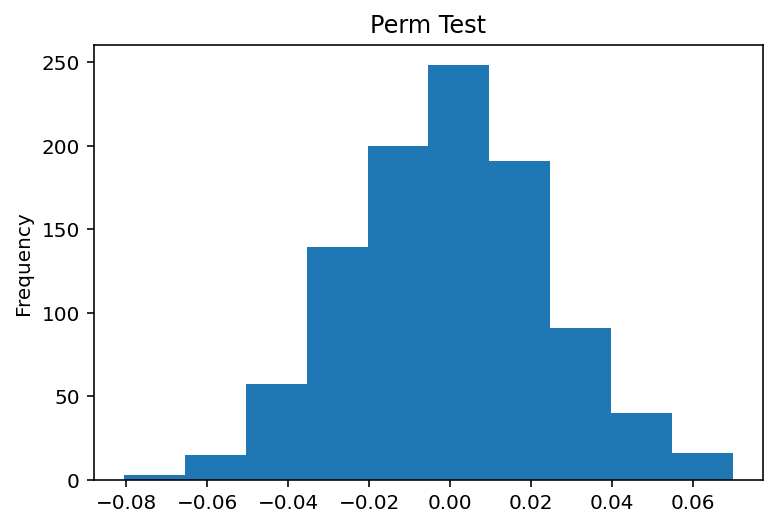

In [98]:
X = final_data.drop('rank_now', axis=1)
y = final_data['rank_now']

rank = FunctionTransformer(rank_check)
agebin=FunctionTransformer(binhelper)
racebinary=FunctionTransformer(racehelper)
types = X.dtypes
cat_cols = types.loc[types == object].index
quant_cols = types.loc[types != object].index
cat_process = ('cat_processing', Pipeline([('one-hot', OneHotEncoder(handle_unknown='ignore'))]),cat_cols)
quan_process = ('qua_processing', Pipeline([('scaler', StandardScaler())]), quant_cols)
comm_process = ('comm', Pipeline([('comm_check', rank)]), ["command_at_incident", "command_now"])
cat_process2 = ("yep", Pipeline([("race",racebinary)]),"complainant_ethnicity")
cat_process3 = ("yep2", Pipeline([("race",agebin)]),"complainant_age_incident")
ct = ColumnTransformer([comm_process, cat_process2, cat_process3, cat_process, quan_process], remainder='passthrough')
pl = Pipeline([('allegations', AllegationNum()), ('features', ct), ('classifier', DecisionTreeClassifier(max_depth=10))])
#pl = Pipeline([('features', ct), ('classifier', DecisionTreeClassifier(max_depth=10))])
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)
pl.fit(Xtrain,ytrain)
preds = pl.predict(Xtest)
results = Xtest
results['prediction'] = preds
results['rank_now'] = ytest
results['is_white'] = (results.mos_ethnicity == 'White').replace({True:'White', False:"POC"})
obs = results.groupby('is_white').apply(lambda x: metrics.accuracy_score(x.rank_now, x.prediction)).diff().iloc[-1]
stats = []
for _ in range(1000):
    s = (
        results[['is_white', 'prediction', 'rank_now']]
        .assign(is_white=results.is_white.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_white')
        .apply(lambda x: metrics.accuracy_score(x.rank_now, x.prediction))
        .diff()
        .iloc[-1]
    )
    stats.append(s)

print(pd.Series(stats <= obs).mean())
pd.Series(stats).plot(kind='hist', title='Perm Test')
